<h2><center> <span style = "font-family: Babas; font-size: 2em;"> E-commerce Text Classification </span> </center></h2>
<h4><center> <span style = "font-family: Babas; font-size: 2em;"> Part 3. Word2Vec Modeling </span> </center></h4>
<h4><center> <span style = "font-family: Babas; font-size: 2em;"> Sugata Ghosh </span> </center></h4>

---

### Overview

The objective of the project is to classify [**e-commerce**](https://en.wikipedia.org/wiki/E-commerce) products into four categories, based on its description available in the e-commerce platforms. The categories are: `Electronics`, `Household`, `Books`, and `Clothing & Accessories`. We carried out the following steps in this notebook:

- Employed a few selected [**text normalization**](https://en.wikipedia.org/wiki/Text_normalization) processes, namely **convertion to lowercase** and **substitution of [contractions](https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions)** on the raw data on product descriptions

- Used Google's pre-trained [**Word2Vec**](https://en.wikipedia.org/wiki/Word2vec) model on the tokens, obtained from the partially normalized descriptions, to get the [**embeddings**](https://en.wikipedia.org/wiki/Word_embedding)

- The embeddings are then converted to [**compressed sparse row**](https://en.wikipedia.org/wiki/Sparse_matrix) (CSR) format

- Used several classifiers, namely *logistic regression*, *k-nearest neighbors classifier*, *decision tree*, *linear support vector machine*, *naive Bayes*, *random forest*, *linear discriminant analysis classifier*, *stochastic gradient descent classifier*, *ridge classifier*, *XGBoost*, *AdaBoost*, *CatBoost*, *neural network* for **baseline modeling**

- Performed [**hyperparameter tuning**](https://en.wikipedia.org/wiki/Hyperparameter_optimization) on [**XGBoost**](https://en.wikipedia.org/wiki/XGBoost) classifier

- Employed the model with the highest validation accuracy to predict the labels of the test observations and obtained a test accuracy of $0.941748$

---

### Contents

- **Preliminaries**
    - Data
    - Train-Validation-Test Split
    - Text Normalization
- **Word2Vec Model**
    - Word Embedding
    - Baseline Modeling
    - Hyperparameter Tuning
- **Final Prediction and Evaluation**
- **Acknowledgements**
- **References**

### Importing libraries

In [1]:
# File system manangement
import time, psutil, os

# Data manipulation
import numpy as np
import pandas as pd

# Plotting and visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_theme()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# NLP
import nltk
from nltk.tokenize import RegexpTokenizer

# Scipy
import scipy
from scipy import sparse
from scipy.sparse import csr_matrix

# Train-test split and cross validation
from sklearn.model_selection import train_test_split, ParameterGrid

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
import catboost as ctb

# Model evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score

# Deep learning
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense

# Others
import gensim
from sklearn.decomposition import TruncatedSVD

### Runtime and memory usage

In [2]:
# Recording the starting time, complemented with a stopping time check in the end to compute process runtime
start = time.time()

# Class representing the OS process and having memory_info() method to compute process memory usage
process = psutil.Process(os.getpid())

# Preliminaries

- **Data**
- **Train-Validation-Test Split**
- **Text Normalization**

## Data

**Original source:** **https://doi.org/10.5281/zenodo.3355823**

**Kaggle dataset:** **https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification**

The dataset has been scraped from Indian e-commerce platform(s). It contains e-commerce text data for four categories: `Electronics`, `Household`, `Books` and `Clothing & Accessories`. Roughly speaking, these four categories cover $80\%$ of any e-commerce website, by and large. The dataset is in *.csv* format and consists of two columns. The first column gives the target class name and the second column gives the datapoint, which is the description of the product from the e-commerce website. We insert column names and swap the columns, to put the target column at the right.

In [3]:
# Loading and customizing the data
data = pd.read_csv(
    'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/Dataset/ecommerceDataset.csv', 
    names = ['label', 'description']
)
data = data[['description', 'label']]

print(pd.Series({"Memory usage": "{:.2f} MB".format(data.memory_usage().sum()/(1024*1024)), 
                 "Dataset shape": "{}".format(data.shape)}).to_string())
data

Memory usage        0.77 MB
Dataset shape    (50425, 2)


,description,label
0,Paper Plane Design Framed Wall Hanging Motivat...,Household
1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",Household
2,SAF 'UV Textured Modern Art Print Framed' Pain...,Household
3,"SAF Flower Print Framed Painting (Synthetic, 1...",Household
4,Incredible Gifts India Wooden Happy Birthday U...,Household
...,...,...
50420,Strontium MicroSD Class 10 8GB Memory Card (Bl...,Electronics
50421,CrossBeats Wave Waterproof Bluetooth Wireless ...,Electronics
50422,Karbonn Titanium Wind W4 (White) Karbonn Titan...,Electronics
50423,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou...",Electronics


In [4]:
# Example description
data['description'].iloc[0]

'Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour and style to your living space with this digitally printed painting. Some are for pleasure and some for eternal blis

In [5]:
# Missing values and duplicate observations
print(pd.Series({"Number of observations with missing values": len(data) - len(data.dropna()),
                 "Number of duplicate observations": data.duplicated().sum()}).to_string())

Number of observations with missing values        1
Number of duplicate observations              22622


In [6]:
data.dropna(inplace = True) # Dropping observations with missing values
data.drop_duplicates(inplace = True) # Dropping duplicate observations
data.reset_index(drop = True, inplace = True) # Resetting index

In [7]:
# Manual encoding of labels
label_dict = {'Electronics': 0, 'Household': 1, 'Books': 2, 'Clothing & Accessories': 3}
data.replace({'label': label_dict}, inplace = True)

print(pd.Series({"Memory usage": "{:.2f} MB".format(data.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data.shape)}).to_string())
data

Memory usage        0.42 MB
Dataset shape    (27802, 2)


,description,label
0,Paper Plane Design Framed Wall Hanging Motivat...,1
1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",1
2,SAF 'UV Textured Modern Art Print Framed' Pain...,1
3,"SAF Flower Print Framed Painting (Synthetic, 1...",1
4,Incredible Gifts India Wooden Happy Birthday U...,1
...,...,...
27797,Micromax Bharat 5 Plus Zero impact on visual d...,0
27798,Microsoft Lumia 550 8GB 4G Black Microsoft lum...,0
27799,"Microsoft Lumia 535 (Black, 8GB) Colour:Black ...",0
27800,Karbonn Titanium Wind W4 (White) Karbonn Titan...,0


In [8]:
# Splitting the dataset by label
data_e = data[data['label'] == 0] # Electronics
data_h = data[data['label'] == 1] # Household
data_b = data[data['label'] == 2] # Books
data_c = data[data['label'] == 3] # Clothing & Accessories

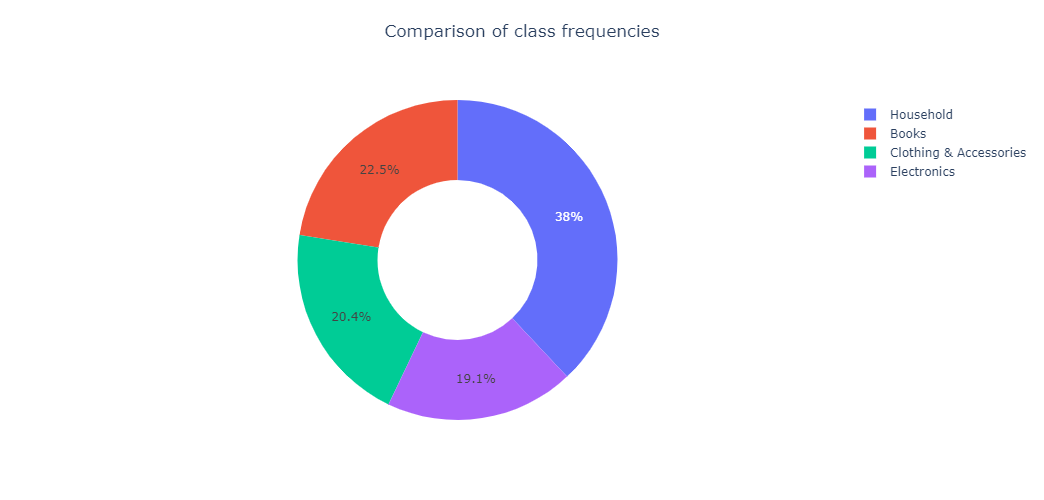

In [9]:
# Visualization of class frequencies
values = np.array([len(data_e), len(data_h), len(data_b), len(data_c)])
labels = ['Electronics', 'Household', 'Books', 'Clothing & Accessories']
fig = go.Figure(data = [go.Pie(values = values, labels = labels, hole = 0.5, textinfo = 'percent', title = " ")])
text_title = "Comparison of class frequencies"
fig.update_layout(height = 500, width = 800, showlegend = True, title = dict(text = text_title, x = 0.5, y = 0.95)) 
fig.show()

## Train-Validation-Test Split

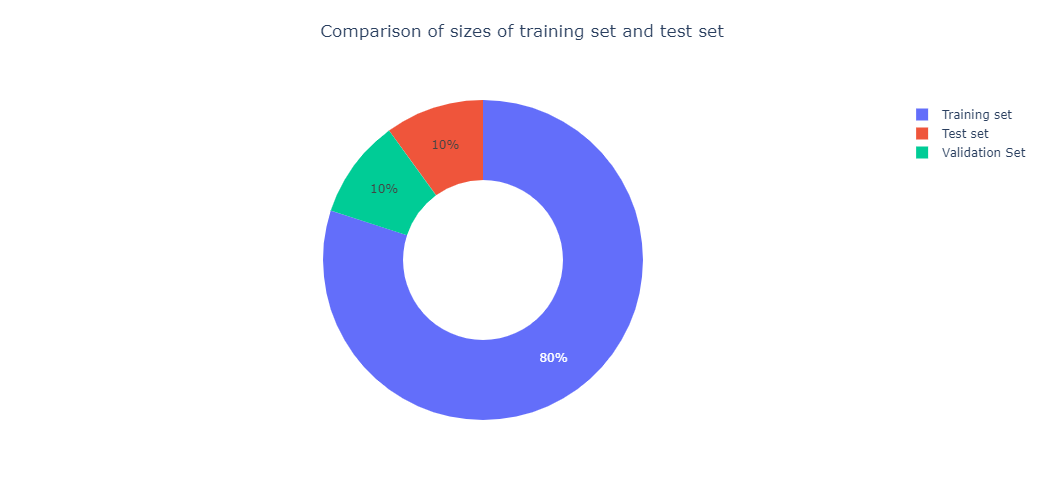

In [10]:
# Feature-target split
X, y = data.drop('label', axis = 1), data['label']

# Train-test split (from complete data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)
data_train = pd.concat([X_train, y_train], axis = 1)

# Validation-test split (from test data)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 40)
data_val, data_test = pd.concat([X_val, y_val], axis = 1), pd.concat([X_test, y_test], axis = 1)

# Comparison of sizes of training set and test set
values = np.array([len(data_train), len(data_val), len(data_test)])
labels = ['Training set', 'Validation Set', 'Test set']
fig = go.Figure(data = [go.Pie(values = values, labels = labels, hole = 0.5, textinfo = 'percent', title = " ")])
text_title = "Comparison of sizes of training set and test set"
fig.update_layout(height = 500, width = 800, showlegend = True, title = dict(text = text_title, x = 0.5, y = 0.95)) 
fig.show()

## Text Normalization

Standard text normalization processes like **stemming**, **lemmatization** or **removal of stop words** are not recommended when we have pre-trained embeddings. The reason behind this is that valuable information, which could be used by the neural network, is lost by those preprocessing steps. Here we shall consider a few selected text normalization processes only, before we feed the tokenized words to the pre-trained model to get the embeddings.

In [11]:
# RegexpTokenizer
regexp = RegexpTokenizer("[\w']+")

In [12]:
# Relevant text normalization processes
def convert_to_lowercase(text): return text.lower()
contractions_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_contractions.json'
contractions_dict = pd.read_json(contractions_url, typ = 'series')
contractions_list = list(contractions_dict.keys())
def convert_contractions(text):
    words = []
    for word in regexp.tokenize(text):
        if word in contractions_list:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()
    return " ".join(words)

In [13]:
# Text normalization for Word2Vec
for df in [data_train, data_val, data_test]:
    df['tokens'] = (df["description"].apply(convert_to_lowercase)
                                     .apply(convert_contractions)
                                     .apply(regexp.tokenize))
data_train[['tokens', 'label']]

,tokens,label
15525,"[practical, approach, to, acupuncture, 1, abou...",2
1536,"[nice, goods, leatherette, office, arm, chair,...",1
21984,"[ekan, fashionable, fedora, hat, for, girls, b...",3
25056,"[techyshop, dmx512, professional, concert, sho...",0
25213,"[marantz, tt5005, fully, automatic, belt, driv...",0
...,...,...
23992,"[apple, ipad, pro, mpf12hn, a, tablet, 10, 5, ...",0
27640,"[printelligent, laptop, skins, stickers, super...",0
14501,"[the, challenger, sale, taking, control, of, t...",2
14555,"[international, mathematics, olympiad, work, b...",2


# Word2Vec Model

- **Word Embedding**
- **Baseline Modeling**
- **Hyperparameter Tuning**

In the context of [**natural language processing**](https://en.wikipedia.org/wiki/Natural_language_processing) (NLP), **word embeddings** are used for representing a word in terms of a real-valued vector that encodes the meaning of the word such that the words that are close in the vector space are expected to be similar in meaning. It can capture the context of a word in a document, as well as identify semantic and syntactic similarity and other contextual relations with other words in the document.

**Word2Vec** is a specific word-embedding technique that uses a neural network model to learn word associations from a reasonably large corpus of text. After training, the model can detect similar words and recommend words to complete a partial sentence. As its name suggests, word2vec maps each distinct word to a vector, which is assigned in such a way that the level of semantic similarity between words is indicated by a simple mathematical operation on the vectors that the words are mapped to (for instance, the cosine similarity between the vectors).

## Word Embedding

In [14]:
# Loading the pre-trained Word2Vec model
word2vec_path = '../input/google-word2vec/GoogleNews-vectors-negative300.bin'
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary = True)

In [15]:
# Some useful functions for Word2Vec
def get_average_word2vec(tokens_list, vector, generate_missing = False, k = 300):
    if len(tokens_list) < 1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis = 0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, tokens, generate_missing = False):
    embeddings = tokens.apply(lambda x: get_average_word2vec(x, vectors, generate_missing = generate_missing))
    return list(embeddings)

def plot_embedding(X, y):
    truncated_SVD = TruncatedSVD(n_components = 2)
    truncated_SVD.fit(X)
    scores = truncated_SVD.transform(X)
    color_mapper = {label:idx for idx, label in enumerate(set(y))}
    color_column = [color_mapper[label] for label in y]
    colors = ['red', 'blue', 'green', 'black']
        
    plt.scatter(scores[:, 0], scores[:, 1], s = 8, alpha = 0.8, c = y, cmap = matplotlib.colors.ListedColormap(colors))
    red_patch = mpatches.Patch(color = 'red', label = 'Electronics')
    blue_patch = mpatches.Patch(color = 'blue', label = 'Household')
    green_patch = mpatches.Patch(color = 'green', label = 'Books')
    black_patch = mpatches.Patch(color = 'black', label = 'Clothing & Accessories')
    plt.legend(handles = [red_patch, blue_patch, green_patch, black_patch], prop = {"size": 12})

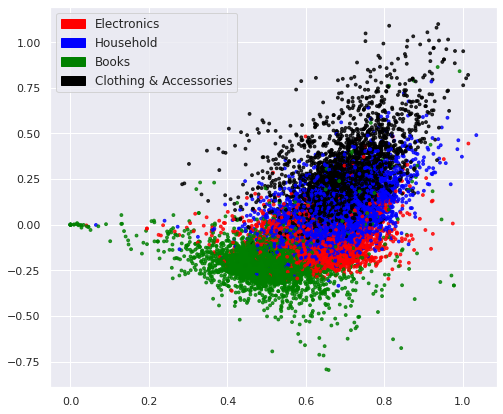

In [16]:
# Word2Vec embedding
X_train_vec = get_word2vec_embeddings(word2vec, data_train['tokens'])
X_val_vec = get_word2vec_embeddings(word2vec, data_val['tokens'])
X_test_vec = get_word2vec_embeddings(word2vec, data_test['tokens'])

fig = plt.figure(figsize = (8, 7))          
plot_embedding(X_train_vec, y_train)
plt.show()

In [17]:
# Converting to Compressed Sparse Row matrix
X_train_csr = scipy.sparse.csr_matrix(X_train_vec)
X_val_csr = scipy.sparse.csr_matrix(X_val_vec)
X_test_csr = scipy.sparse.csr_matrix(X_test_vec)

## Baseline Modeling

In [18]:
# Classifiers
names = [
    "Logistic Regression",
    "KNN Classifier",
    "Decision Tree",
    "Linear SVM",
    "Naive Bayes",
    "Random Forest",
    "LDA Classifier",
    "SGD Classifier",
    "Ridge Classifier",
    "XGBoost",
    "AdaBoost",
    "CatBoost",
    "Neural Network"
]

models = [
    LogisticRegression(max_iter = 1000),
    KNeighborsClassifier(n_neighbors = 149, n_jobs = -1),
    DecisionTreeClassifier(),
    svm.SVC(kernel = 'linear'),
    GaussianNB(),
    RandomForestClassifier(n_estimators = 100),
    LinearDiscriminantAnalysis(),
    SGDClassifier(loss = 'hinge'),
    RidgeClassifier(),
    XGBClassifier(),
    AdaBoostClassifier(),
    ctb.CatBoostClassifier(silent = True),
    "Neural Network" # To be specified in the next code block
]

In [19]:
# Function to return summary of baseline models
def score(X_train, y_train, X_val, y_val, names = names, models = models):
    score_df, score_train, score_val = pd.DataFrame(), [], []
    for model in models:
        if model == "Neural Network":
            model = Sequential()
            model.add(Dense(128, input_dim = X_train.shape[-1], activation = 'relu'))
            model.add(Dense(64, activation = 'relu'))
            model.add(Dense(32, activation = 'relu'))
            model.add(Dense(16, activation = 'relu'))
            model.add(Dense(8, activation = 'relu'))
            model.add(Dense(4)) # activation = 'softmax' is traded with from_logits = True in model.compile loss 
                                # for numerical stability
            model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                          optimizer = 'adam', metrics = ['accuracy'])
            model.fit(X_train.toarray(), y_train, 
                      validation_data = (X_val.toarray(), y_val), 
                      epochs = 100, batch_size = 64, verbose = 0)
            train_pred, val_pred = model.predict(X_train), model.predict(X_val)
            y_train_pred = [np.argmax(train_pred[i]) for i in range(len(train_pred))]
            y_val_pred = [np.argmax(val_pred[i]) for i in range(len(val_pred))]
        elif str(model) in ['GaussianNB()', 'LinearDiscriminantAnalysis()']:
            model.fit(X_train.toarray(), y_train)
            y_train_pred, y_val_pred = model.predict(X_train.toarray()), model.predict(X_val.toarray())
        else:
            model.fit(X_train, y_train)
            y_train_pred, y_val_pred = model.predict(X_train), model.predict(X_val)
        score_train.append(accuracy_score(y_train, y_train_pred))
        score_val.append(accuracy_score(y_val, y_val_pred))
    score_df["Classifier"], score_df["Training accuracy"], score_df["Validation accuracy"] = names, score_train, score_val
    score_df.sort_values(by = 'Validation accuracy', ascending = False, inplace = True)
    return score_df

In [20]:
# Summary of baseline models
score(X_train_csr, y_train, X_val_csr, y_val, names = names, models = models)

2022-09-27 10:49:30.375991: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-09-27 10:49:31.063777: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


,Classifier,Training accuracy,Validation accuracy
9,XGBoost,0.999955,0.944964
11,CatBoost,0.989479,0.943165
12,Neural Network,0.996763,0.934892
3,Linear SVM,0.937233,0.934173
0,Logistic Regression,0.931613,0.929856
5,Random Forest,0.999955,0.928777
7,SGD Classifier,0.930848,0.928417
8,Ridge Classifier,0.921901,0.925180
6,LDA Classifier,0.918754,0.916547
1,KNN Classifier,0.913268,0.912590


## Hyperparameter Tuning

We perform [**hyperparameter tuning**](https://en.wikipedia.org/wiki/Hyperparameter_optimization) on the best performing baseline model.

In [21]:
# Hyperparameter tuning for XGBoost
xgb = XGBClassifier()
params_xgb = {
    'learning_rate': [0.03, 0.3],
    'min_child_weight': [0, 10],
    'n_estimators': [200],
    'reg_lambda': [1, 2],
    'seed': [40]
}

best_model_xgb, best_params, best_score, count = xgb, ParameterGrid(params_xgb)[0], 0, 0
for g in ParameterGrid(params_xgb):
    time_start = time.time()
    count += 1
    print(f"Gridpoint #{count}: {g}")
    xgb.set_params(**g)
    xgb.fit(X_train_csr, y_train)
    y_train_pred, y_val_pred = xgb.predict(X_train_csr), xgb.predict(X_val_csr)
    score_train, score_val = accuracy_score(y_train, y_train_pred), accuracy_score(y_val, y_val_pred)
    time_stop = time.time()
    m, s = int(time_stop - time_start) // 60, int(time_stop - time_start) % 60
    print(f"Training accuracy: {score_train}, Validation accuracy: {score_val}, Runtime: {m}m{s}s")
    print(" ")
    if score_val > best_score:
        best_params, best_score = g, score_val

best_model = XGBClassifier()
best_model.set_params(**best_params)
print(f"Best model: {best_model}")
print(" ")
print(f"Best parameters: {best_params}")
print(f"Best validation accuracy: {best_score}")

Gridpoint #1: {'learning_rate': 0.03, 'min_child_weight': 0, 'n_estimators': 200, 'reg_lambda': 1, 'seed': 40}
Training accuracy: 0.9734724158086417, Validation accuracy: 0.9327338129496403, Runtime: 18m2s
 
Gridpoint #2: {'learning_rate': 0.03, 'min_child_weight': 0, 'n_estimators': 200, 'reg_lambda': 2, 'seed': 40}
Training accuracy: 0.9722584416168337, Validation accuracy: 0.9302158273381295, Runtime: 17m57s
 
Gridpoint #3: {'learning_rate': 0.03, 'min_child_weight': 10, 'n_estimators': 200, 'reg_lambda': 1, 'seed': 40}
Training accuracy: 0.96974056921901, Validation accuracy: 0.9316546762589928, Runtime: 17m4s
 
Gridpoint #4: {'learning_rate': 0.03, 'min_child_weight': 10, 'n_estimators': 200, 'reg_lambda': 2, 'seed': 40}
Training accuracy: 0.968886291084034, Validation accuracy: 0.9330935251798561, Runtime: 17m5s
 
Gridpoint #5: {'learning_rate': 0.3, 'min_child_weight': 0, 'n_estimators': 200, 'reg_lambda': 1, 'seed': 40}
Training accuracy: 0.999955037992896, Validation accuracy:

# Final Prediction and Evaluation

We employ the model with the highest validation accuracy to predict the labels of the test observations and report the resulting test accuracy.

In [22]:
# Function to compute and print confusion matrix
def conf_mat(y_test, y_test_pred, figsize = (10, 8), font_scale = 1.2, annot_kws_size = 16):
    class_names = [0, 1, 2, 3] # ['Electronics', 'Household', 'Books', 'Clothing & Accessories']
    tick_marks_y = [0.5, 1.5, 2.5, 3.5]
    tick_marks_x = [0.5, 1.5, 2.5, 3.5]
    confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    confusion_matrix_df = pd.DataFrame(confusion_matrix, range(4), range(4))
    plt.figure(figsize = figsize)
    sns.set(font_scale = font_scale) # label size
    plt.title("Confusion Matrix")
    sns.heatmap(confusion_matrix_df, annot = True, annot_kws = {"size": annot_kws_size}, fmt = 'd') # font size
    plt.yticks(tick_marks_y, class_names, rotation = 'vertical')
    plt.xticks(tick_marks_x, class_names, rotation = 'horizontal')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.show()

Test accuracy    0.941748
 


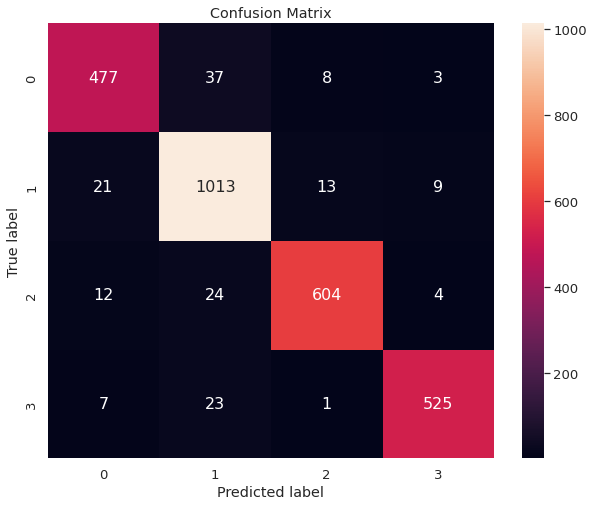

In [23]:
# Prediction and evaluation on test set
best_model.fit(X_train_csr, y_train)
y_test_pred = best_model.predict(X_test_csr)
score_test = accuracy_score(y_test, y_test_pred)
print(pd.Series({"Test accuracy": score_test}).to_string())
print(" ")
conf_mat(y_test, y_test_pred, figsize = (10, 8), font_scale = 1.2, annot_kws_size = 16) # Confusion matrix
print(" ")

# Acknowledgements

- [**A Guide on XGBoost hyperparameters tuning**](https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning) by [**Prashant Banerjee**](https://www.kaggle.com/prashant111)
- [**Ecommerce Text Classification**](https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification) dataset
- [**Gautam. (2019). E commerce text dataset (version - 2) [Data set]. *Zenodo*.**](https://doi.org/10.5281/zenodo.3355823)

# References

- [**List of English contractions**](https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions)
- [**E-commerce**](https://en.wikipedia.org/wiki/E-commerce)
- [**Hyperparameter optimization**](https://en.wikipedia.org/wiki/Hyperparameter_optimization)
- [**Lemmatization**](https://en.wikipedia.org/wiki/Lemmatisation)
- [**Natural language processing**](https://en.wikipedia.org/wiki/Natural_language_processing)
- [**Part of speech**](https://en.wikipedia.org/wiki/Part_of_speech)
- [**Sparse matrix**](https://en.wikipedia.org/wiki/Sparse_matrix)
- [**Stemming**](https://en.wikipedia.org/wiki/Stemming)
- [**Stop word**](https://en.wikipedia.org/wiki/Stop_word)
- [**Text corpus**](https://en.wikipedia.org/wiki/Text_corpus)
- [**Text normalization**](https://en.wikipedia.org/wiki/Text_normalization)
- [**Word embedding**](https://en.wikipedia.org/wiki/Word_embedding)
- [**Word2Vec**](https://en.wikipedia.org/wiki/Word2vec)
- [**XGBoost**](https://en.wikipedia.org/wiki/XGBoost)

In [24]:
# Runtime and memory usage
stop = time.time()
print(pd.Series({"Process runtime": "{:.2f} seconds".format(float(stop - start)),
                 "Process memory usage": "{:.2f} MB".format(float(process.memory_info()[0]/(1024*1024)))}).to_string())

Process runtime         10535.53 seconds
Process memory usage          5921.17 MB
